# Some simulations of Habits in Labor Supply

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

Here is some text describing the rational habits model of labor supply with non-separable preferences. It is non-separable in terms of labor, but it is indeed separable in terms of labor supply and consumption.

In [2]:
# Using Bover's estimates to calibrate the model
# Based on Table 1, Column 2 Estimates
#Aside from the T, this block of code is obsolete, but I am keeping it here in case I need it for the future
gamma_h = 1768.1516
gamma_c = 4454.0084
varphi = 0.2205
rho = 0.2429
r = 0.2429
beta_const = 0.1845
beta_children = -0.0238
num_children=1.79 #this is the mean number of children (Table A1)
B_1 = beta_const + beta_children*num_children
B_2 = 1 - B_1

#sim_size=10000
T=40

In [3]:
np.random.seed(1126)
#Wages based on summary stats table
mean_wage= 4.66
sd_wage = 2.72
#Wage = np.random.normal(mean_wage, sd_wage,sim_size)
#Wage[Wage<=1.60]=1.60 #Setting the lower wages equal to min wage
Wage=mean_wage #let's just do a simulation for a single person at the moment

In [4]:
def life_cycle(gamma_h, gamma_c, varphi, rho, r, beta_const=0.1845, beta_children=-0.0238, num_children=1.79, Wage=4.66, T=40):
#should solve everything with a single function
    B_1 = beta_const + beta_children*num_children
    B_2 = 1 - B_1
    
    #trying to properly calculate lagrage multiplier for period 1 (Equation 8)
    phiR=varphi/(1+r)
    discount_factor = 1/(1+rho)
    first_part = (1-discount_factor) / (1-discount_factor**T)
    Rminus1 = 1/(1+r)
    
    #I think I calculated the "second_part" incorrectly
    wp = lambda factor, time: (1-factor**time)/(1-factor)
    all_ts = np.arange(T,0,-1)
    wplus_factor = wp(phiR, all_ts)
    wplus = wplus_factor*Wage
    all_ts_forward = np.arange(0,T)
    R_array=Rminus1**all_ts_forward
    second_part=sum(R_array*(gamma_h*wplus-gamma_c))
    lagrange_inverse=first_part*second_part

    cons1=gamma_c+B_2 * lagrange_inverse
    h1=gamma_h - B_1/(wplus[0])*lagrange_inverse
    
    
    #now calculating a similar thing for the other periods
    hours=[h1]
    consumption=[cons1]
    bank_balance = [0]
    b2 = (h1*Wage-cons1)*(1+r)
    bank_balance.append(b2)
    first_p = lambda factor, time : (1-factor)/(1-factor**time)
    for i in range(T-1):
        first_part=first_p(discount_factor, T-i-1)
        second_part=sum(R_array[0:T-1-i]*(gamma_h*wplus[0:T-1-i]-gamma_c))+bank_balance[i+1]+varphi*hours[i]*wplus[i+1]
        lagrange_inverse=first_part*second_part

        consumption.append(gamma_c+B_2 * lagrange_inverse)
        hours.append(gamma_h - B_1/(wplus[i+1])*lagrange_inverse+varphi*hours[i])
        bank_balance.append((hours[i+1]*Wage - consumption[i+1])*(1+r))
    
    return consumption, hours, bank_balance

In [5]:
#calibration for first original
gamma_h1 = 1768.1516
gamma_c1 = 4454.0084
varphi1 = 0.2205
rho1 = 0.2429
r1 = 0.2429

#calibration for original
gamma_h2 = 1768.1516
gamma_c2 = 4454.0084
varphi2 = 0.2205
rho2 = 0.08
r2 = 0.02

#counterfactual
gamma_h3 = 1768.1516
gamma_c3 = 4454.0084
varphi3 = 0.3
rho3 = 0.08
r3 = 0.02

#no habit
gamma_h4 = 1768.1516
gamma_c4 = 4454.0084
varphi4 = 0.0
rho4 = 0.08
r4 = 0.02

c,h,b = life_cycle(gamma_h=gamma_h1, gamma_c=gamma_c1, varphi=varphi1, rho=rho1, r=r1)
c2,h2,b2=life_cycle(gamma_h=gamma_h2, gamma_c=gamma_c2, varphi=varphi2, rho=rho2, r=r2)
c3, h3, b3=life_cycle(gamma_h=gamma_h3, gamma_c=gamma_c3, varphi=varphi3, rho=rho3, r=r3)
c4,h4,b4 = life_cycle(gamma_h=gamma_h4, gamma_c=gamma_c4, varphi=varphi4, rho=rho4, r=r4)

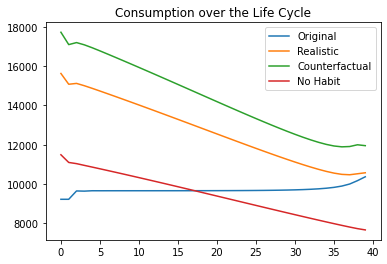

In [6]:
plt.figure()
plt.plot(c, label='Original')
plt.plot(c2, label='Realistic')
plt.plot(c3, label='Counterfactual')
plt.plot(c4, label='No Habit')
plt.legend()
plt.title('Consumption over the Life Cycle')
plt.savefig('Figures/consumption_lc.png', dpi=600)
#plt.show()

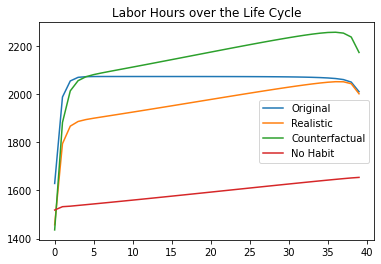

In [7]:
plt.figure()
plt.plot(h, label='Original')
plt.plot(h2, label='Realistic')
plt.plot(h3, label='Counterfactual')
plt.plot(h4, label='No Habit')
plt.legend()
plt.title('Labor Hours over the Life Cycle')
plt.savefig('Figures/hours_lc.png', dpi=600)
#plt.show()

Text(0.5, 1.0, 'Bank Balances over the Life Cycle')

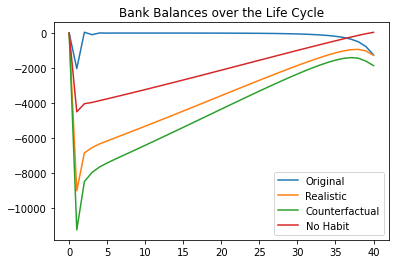

In [8]:
plt.figure()
plt.plot(b, label='Original')
plt.plot(b2, label='Realistic')
plt.plot(b3, label='Counterfactual')
plt.plot(b4, label='No Habit')
plt.legend()
plt.title('Bank Balances over the Life Cycle')
#plt.show()

Let's try calculating some elasticities.
The basic elasticity given is
$$\epsilon_{it} = \frac{w}{h}\frac{\partial h}{\partial w} $$
The authors use the following approximation:
$$\epsilon = \frac{\gamma_h +\varphi h_{i,t-1}}{h_{i,t}} -1 $$

Evaluating at the sample means using the Bover calibrations, we get

In [9]:
def epsilon_calc(var, gamma_h=gamma_h, varphi=varphi):
    epsilon = (gamma_h +varphi *np.mean(var[0:T-1]))/np.mean(var)-1
    return epsilon

def eta_alph_calc(hour_var, b1=B_1, gamma_h=gamma_h, r=r, varphi=varphi, alpha=Wage, wage=Wage):
    eta_alpha = (-1)*b1 *(gamma_h + varphi*r*np.mean(hour_var[1:T-1])/(1+r))*alpha/wage/np.mean(hour_var)
    return eta_alpha
#in this setting eta_delta does not matter since the wage is not changing for individuals

In [10]:
epsilon=epsilon_calc(h, varphi=varphi1)
epsilon2=epsilon_calc(h2, varphi=varphi2)
epsilon3=epsilon_calc(h3, varphi=varphi3)
epsilon4=epsilon_calc(h4, varphi=varphi4)
eta1=eta_alph_calc(h, r=r1, varphi=varphi1)
eta2=eta_alph_calc(h2, r=r2, varphi=varphi2)
eta3=eta_alph_calc(h3, r=r3, varphi=varphi3)
eta4=eta_alph_calc(h4, r=r4, varphi=varphi4)

In [11]:
epsilons = [epsilon, epsilon2, epsilon3, epsilon4]
etas=[eta1,eta2,eta3, eta4]
simulation=['Original', "Realistic", "Counterfactual", "No Habit"]
elast = pd.DataFrame({'Simulation':simulation,'epsilons':epsilons, 'etas':etas})
elast=elast.set_index('Simulation')
elast.head()

,epsilons,etas
Simulation,,
Original,0.080567,-0.128176
Realistic,0.123192,-0.128725
Counterfactual,0.124626,-0.117869
No Habit,0.111189,-0.157675


In [12]:
elast.to_latex('Tables/elast_table.tex', header=['$\epsilon$', '$\eta^{\\alpha}$'], escape=False, float_format='%.4f', label='tab:elasts', caption='Simulated Elasticities')

In [13]:
calibrations=pd.DataFrame({"Simulation":simulation, "gamma_h":[gamma_h1, gamma_h2, gamma_h3, gamma_h4], "gamma_c":[gamma_c1, gamma_c2, gamma_c3, gamma_c4],"varphi":[varphi1, varphi2, varphi3, varphi4], "rho":[rho1, rho2, rho3, rho4], "r":[r1,r2,r3,r4]})
calibrations=calibrations.set_index('Simulation')
calibrations.head()

,gamma_h,gamma_c,varphi,rho,r
Simulation,,,,,
Original,1768.1516,4454.0084,0.2205,0.2429,0.2429
Realistic,1768.1516,4454.0084,0.2205,0.0800,0.0200
Counterfactual,1768.1516,4454.0084,0.3000,0.0800,0.0200
No Habit,1768.1516,4454.0084,0.0000,0.0800,0.0200


In [14]:
calibrations.to_latex('Tables/calibration_table.tex', header=['$\gamma_h$', '$\gamma_c$', "$\\varphi$", "$\\rho$", 'r'], escape=False, float_format='%.4f', label='tab:calibs', caption='Calibrated Parameters')